<a href="https://colab.research.google.com/github/13693763686/data-analysis/blob/master/scikit-learn%20notebook/decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 泰坦尼克号幸存者的预测


## 导入所需要的库

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [ ]:
import matplotlib.pyplot as plt

## 导入数据集，探索数据特征，注意数据的特征的注解

In [ ]:
data = pd.read_csv("data.csv")

In [ ]:
data.info()
#初步观察，数据中有许多缺失值，需要进行特征工程进行决策
#如果这一列值太少，插值不容易且对预测的影响很小，可以考虑删除
#如果缺的值不是特别多，这时可以考虑插值，离散和连续都有独立的方法
#对于离散的值来说，众数可能是好的选择
#对于连续的值来说，平均值和中值都是很好的选择
#这些插值方法，可以利用sklearn的模块，也可以利用numpy的性质手工转换

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 对数据集进行预处理，特别是关于异常值和缺省值

In [ ]:
data.drop(["Cabin","Name","Ticket"],inplace=True,axis=1)
#cabin为上船的地点，name为姓名，票的种类等等与生存与否关系不大，可以删除
#考虑的方面主要为与预测标签的关系，以及缺失的程度

In [ ]:
#注意到年龄是判断的重要因素，而在数据集中处于缺失的状态，大约1/8的缺失的话可以通过插值解决
#插值的方式可以通过简单的单值替换，也可以通过随机森林等高级机器学习模型混合学习来保证准确度
#矩阵分解的插值方法，监督学习的方法都可以作为尝试的方法，如果特征特别重要的话
data["Age"] = data["Age"].fillna(data["Age"].mean())

In [ ]:
#一般的机器学习模型不能处理字符串型的数据，需要对其进行转换
#字符串的数据通常是关于类别的，因此对其离散化为数字即可
#这里要特别注意nominal和ordinal的区别，ordinal具有内生的顺序性，而nominal只是表示不同而已
#还有两种数据是interval和ratio的区别，interval可以比较大小和加减，表示数值之间有差距，且差距可以从某种程度进行衡量，这是与ordinal对应，ordinal之间的差值只是表示不同，且更优秀而已
#也就是说，不能说40度是20度的两倍热，因为0度本身不代表没有温度，20度也不是0度的无穷大热，且不同温度之间的变化所需要吸取的热量也是不同的，不同的差距的比较也是没有意义的
#对于数学中经常考虑的数据，实数都是ration数据，它有确定的0，1就是1，2就是1的两倍，因为内部的物理意义被隔离了，只有抽象的含义，因此从抽象的角度来分析比较好

In [ ]:
datacopy = data # copy the data for experiments below

In [ ]:
#这里演示两种方法对数据进行离散化编码的方式
#利用dataframe的基本操作
data["Sex"] = (data["Sex"] == "male").astype("int")
#利用sklearn中的编码模块
#对于不同的数据，我们有不同的分析方式，对于标签来说，直接利用LabelEncoder编码为不同的数值即可，因为作为标签来说只能是一维列表，只能为ordinal的顺序，因此注意编码的方法
#对于特征矩阵来讲，通常来说我们会采用ordinal的方式，但对于一些其它的nominal数据，我们可能需要onehot的形式
#这里对于性别来讲，是典型的nominal数据，但由于是2分类问题，因此它们是一致的
#下面对于几种方法分别试验,演示其使用方法

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label = data["Sex"]

In [ ]:
label.value_counts()

1    577
0    314
Name: Sex, dtype: int64

In [ ]:
le = LabelEncoder()  #实例化我们的encoder对象，准备编码

In [ ]:
le = le.fit(label)  #对label进行fit操作，做好准备工作，记录下编码方式

In [ ]:
le.classes_      #查看encoder的fit情况，观察array的顺序，这会决定编码的顺序

array([0, 1])

In [ ]:
label = le.transform(label)  #利用transform方法对label进行转换，当然可以直接利用fit_transform直接进行操作

In [ ]:
label[:5]

array([1, 0, 0, 0, 1])

In [ ]:
#注意上面的赋值方式，操作本身不会对源数据进行修改，会返回一个新的数据，pandas大部分的函数都是如此的特征
label[:10]     #注意结果，male对应的标签号为一，下面用ordinalencoder进行同样的操作

array([1, 0, 0, 0, 1, 1, 1, 1, 0, 0])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal = OrdinalEncoder()

In [ ]:
label = data["Sex"]

In [ ]:
#注意reshape方法是ndarray的方法，需要提前把series转变为ndarray，利用values的属性可以迅速的提取
#利用reshape方法升维,numpy中的操作比series多了很大，因为numpy的ndarray是作为科学计算的基石，可操作性很强
label = label.reshape(-1,1)
label.shape

AttributeError: ignored

In [ ]:
ordinal.fit(label)
#对于ordinal的编码器，它需要接受一个矩阵，当数据只有一个特征时，注意转换为矩阵的形式，根据提示，reshape即可。

In [ ]:
#ordinal编码器以列表的形式存取所有的编码方式，这里面的auto是自动识别的方式，但是应该是可以手动决定顺序的，否则编码的顺序只能按照字母表的顺序
type(ordinal.categories_)

In [ ]:
#现在尝试为编码设置顺序，直接操控其内部的label属性应该是可以的，毕竟python没有严格的属性保护，私有变量等等
label = data["Sex"]
le = LabelEncoder()

In [ ]:
#当fit函数没有被call的时候，可以发现classes_属性是没有意义的，会报错
#那么自然的也不可能对其进行操作
le.classes_

In [ ]:
type(le.fit(label))

In [ ]:
#嗯哼，发现classes_成功的被我们修改了
le.classes_ = np.array(["male","female"],dtype=object)

le.classes_

In [ ]:
label.head()

In [ ]:
#验证我们的想法，进行transform操作
le.transform(label)
#确认文档，观察是否有初始值的参数可以设定,然而似乎没有
#其实观察这些过程，实现方式也不过是apply对每列的操作

In [ ]:
data.info()

In [ ]:
#注意到此时只有embarked有三个缺失值，考虑直接删除即可
data.dropna(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 888
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  887 non-null    float64
 1   Survived     887 non-null    float64
 2   Pclass       887 non-null    float64
 3   Sex          887 non-null    float64
 4   Age          887 non-null    float64
 5   SibSp        887 non-null    float64
 6   Parch        887 non-null    float64
 7   Fare         887 non-null    float64
 8   Embarked_C   887 non-null    float64
 9   Embarked_Q   887 non-null    float64
 10  Embarked_C   887 non-null    float64
dtypes: float64(11)
memory usage: 83.2 KB


In [ ]:
#下面对embarked属性进行编码的设置，这时候显然是一个类型变量，而非顺序的变量
#因此我们应当用onehot的方式进行处理，当然我们可以直接利用pandas的get_dummy，但是既然机器学习的包已经封装好，并且更符合机器学习的术语，我们那样用就好
#下面演示其使用方法
from sklearn.preprocessing import OneHotEncoder
one = OneHotEncoder()
enc = one.fit(data["Embarked"].values.reshape(-1,1))

In [ ]:
enc.get_feature_names()
#这个方法可以查看编码器是如何命名这些哑变量的，也可以自己来调整这些名字，通过columns属性可以全部修改，通过rename方法可以单独修改，以字典作为参数

array(['x0_C', 'x0_Q', 'x0_S'], dtype=object)

In [ ]:
#注意transform的结果并不会直接作用到dataframe,仍然需要一定的concat的工作，要注意删除掉原来的变量
result = enc.transform(data[["Embarked"]]).toarray()

In [ ]:
newdata = pd.concat([data.iloc[:,:-1],pd.DataFrame(result)],axis=1)

In [ ]:
#注意列的名字0和1是数字的0和1，同时rename的时候注意指定列参数
newdata = newdata.rename(columns={0:"Embarked_C",1:"Embarked_Q",2:"Embarked_C"})

In [ ]:
data = newdata
data.dropna(inplace=True)

In [ ]:
data.isna()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_C
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
884,False,False,False,False,False,False,False,False,False,False,False
885,False,False,False,False,False,False,False,False,False,False,False
886,False,False,False,False,False,False,False,False,False,False,False
887,False,False,False,False,False,False,False,False,False,False,False


##提取测试集和训练集

In [ ]:
#在提取训练集和测试集之前，通常为了降低计算量已经增加模型的解释力，我们会进行特征选择的过程
#由于这里的特征数目不是很多，因此特征选择的工作就省去了，特征选择的过程放在后续的案例中
#注意训练集和测试集的命名规范
X = data.iloc[:,data.columns != "Survived"]
y = data.iloc[:,data.columns == "Survived"]


In [ ]:
#进行测试集和训练集的分开，当存在许多的超参数时，注意三分的方法
#交叉验证是机器学习非常重要的验证方式，它可以与网格搜索相结合，注意计算量的区别
from sklearn.model_selection import train_test_split
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3)

In [ ]:
#当进行分离的时候，dataframe和series的索引仍然保留原来的形式，很讨厌，后面可能会出奇怪的错误，建议立即进行回复
for i in [Xtrain,Xtest,Ytrain,Ytest]:
  i.set_index = range(i.shape[0])

In [ ]:
Xtrain.head()
#到此时，所有的数据预处理部分算完成了，当然了，这是一个简单的例子，复杂的预处理部分应当包括特征工程的过程，这些打算放在评分卡的处理上面
#当然关于气象的预测的预处理相对更加复杂，因为它需要利用一定的爬虫知识和python脚本编写的能力，也可以作为练习的方面

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_C
264,265.0,3.0,0.0,29.699118,0.0,0.0,7.7500,0.0,0.0,1.0
161,162.0,2.0,0.0,40.000000,0.0,0.0,15.7500,0.0,0.0,1.0
686,687.0,3.0,1.0,14.000000,4.0,1.0,39.6875,0.0,0.0,1.0
489,490.0,3.0,1.0,9.000000,1.0,1.0,15.9000,0.0,0.0,1.0
603,604.0,3.0,1.0,44.000000,0.0,0.0,8.0500,1.0,0.0,0.0


## 导入模型，进行结果的检验，验证模型的效果

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf = DecisionTreeClassifier(random_state=100)
clf = clf.fit(Xtrain,Ytrain)

In [ ]:
#检验模型的效果，调用_score函数，这个函数内部应该是包装着预测加评分方式，可以通过参数指定
#对于分类结果来说，默认的方式就是精确率
score_ = clf.score(Xtest,Ytest)

In [ ]:
#下面进行交叉验证，进行K-fold的检验结果，并且取均值
score = cross_val_score(clf,X,y,cv=10).mean()

In [ ]:
#可以发现准确率集中在75%左右，并不是一个可靠的分类器，于是我们决定通过参数的调整看看能不能有更好的表现
score

0.7430158324821245

In [ ]:
#由于决策树的调整方式主要就是关于过拟合和偏差的情况，下面检验是哪种情况，即检验训练集上的分数,
score = clf.score(Xtrain,Ytrain)
_

0.7430158324821245

In [ ]:
#通过上面的结果发现，这显然是一个偏差的问题，模型本身的能力太差，我们可以考虑使用随机森林
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#调整使用的树的个数为100，后面会对这个超参数进行慢慢地调整
rfc = RandomForestClassifier(n_estimators=100,random_state=100)
rfc = rfc.fit(Xtrain,Ytrain)
#尽管有一个warning的警告，但显然这个training过程可以自己处理，因此就不需要额外的处理了

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
[rfc.score(Xtrain,Ytrain),rfc.score(Xtest,Ytest)]
#这个结果的准确率达到了100%，这显然的过拟合了，我们自然而然的想到要减少树的个数
#这里随机森林的结果还不错，也就不必要再选择更高级的模型的了，简单的总是最先尝试了，也许SVM和boosting可以做的更好

[1.0, 0.8127340823970037]

## 模型的超参数的调整


In [ ]:
#下面首先调整随机森林的数目，检验模型的效果，注意图像的拐点这些东西
scorel = []
for i in range(0,200,10):
  rfc = RandomForestClassifier(n_estimators=i+1,n_jobs=-1,random_state=100)
  score = cross_val_score(rfc,X,y,cv=10).mean()
  scorel.append(score)


In [ ]:
#检查最好的树的个数
print(max(scorel),scorel.index(max(scorel))*10+1)

0.8117083758937692 21


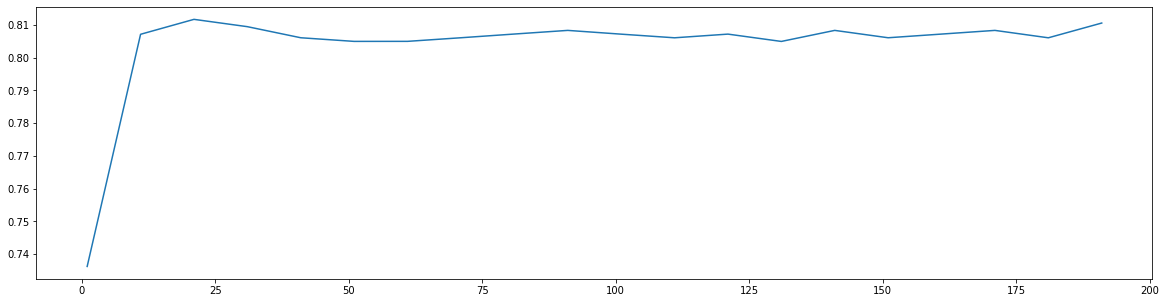

In [ ]:
#从图像的结果来看，随机森林的结果最好也不过是82%的准确率，我们可以尝试对其参数细细调整，或者换用新的模型
#这里处于学习的目的，因为随机森林的调参与决策树和XGBoosting都有关系，这里把其过程详细的写下来
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

In [ ]:
##刚才的过程这的搜索间距是10，这里我们可以细化搜索的范围，从而得到更好的效果
##从图像来安，结果应该在21的左右10个单位的方向搜索，因为后面的10单位间距基本已经比较过了
score1 = []
for i in range(10,31):
  rfc = RandomForestClassifier(n_estimators=i,n_jobs=-1,random_state=100)
  score = cross_val_score(rfc,X,y,cv=10).mean()
  score1.append(score)

In [ ]:
len(score1)

21

In [ ]:
#检查最好的树的个数
print(max(score1),score1.index(max(score1)))

0.8150791624106232 17


In [ ]:
#从上面的结果的话，我们得到了最好的树的个数，它可以作为后续的过程的基本参数，可以发现调整树的个数的最好的结果不过如此了
#下面准备调整max_depth参数，对于这些效果较为确定的参数我们可以通过细化学习曲线慢慢地调整,但是就是很麻烦，我们可以利用网格搜索的一维化直接调整
param_grid = {"max_depth":np.arange(1,20,1)}
rfc = RandomForestClassifier(n_estimators=17,random_state=100)
GS = GridSearchCV(rfc,param_grid=param_grid,cv=10)
GS.fit(X,y)

In [ ]:
GS.best_params_

{'max_depth': 9}

In [ ]:
GS.best_score_

0.8263917262512768

In [ ]:
#后面的参数还可以一个一个调整，这里就不再赘述了
#利用最开始的方法，粗略地检查了一下GS在test上的正确率，达到了94%的结果，比最开始的结果提高了很多
GS.score(Xtest,Ytest)

0.9400749063670412

In [ ]:
#最后再进行一次cross_val_score的检验，确定模型的效果
rfc = RandomForestClassifier(n_estimators=17,max_depth=9,random_state=100)

In [ ]:
#发现结果达到了94%，是还不错的结果，模型可以固定了。
score =  cross_val_score(rfc,X,y,cv=10).mean()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

0.9400749063670412